In [1]:
#Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy.stats import mode
from calendar import monthrange
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
%matplotlib inline

In [2]:
#Reading input files
df = pd.read_csv("../Documents/JK/McKinsey2/train.csv")
df_test = pd.read_csv("../Documents/JK/McKinsey2/test.csv")

In [3]:
df_test.head(5)

,ID,Gender,DOB,Lead_Creation_Date,City_Code,City_Category,Employer_Code,Employer_Category1,Employer_Category2,Monthly_Income,...,Primary_Bank_Type,Contacted,Source,Source_Category,Existing_EMI,Loan_Amount,Loan_Period,Interest_Rate,EMI,Var1
0,APPA70109647212,Male,03/06/88,05/07/16,C10028,C,COM0002222,A,4.0,2150.0,...,P,Y,S122,B,0.0,10000.0,3.0,20.0,372.0,4
1,APPB10687939341,Male,13/07/81,01/07/16,C10003,A,COM0001784,C,4.0,4200.0,...,P,Y,S133,C,0.0,69000.0,5.0,24.0,1985.0,7
2,APPC80449411414,Female,19/11/90,01/07/16,C10009,B,COM0045260,B,4.0,1000.0,...,P,N,S133,B,0.0,NaN,NaN,NaN,NaN,0
3,APPD30665094501,Female,15/10/92,01/07/16,C10005,A,COM0000085,A,3.0,1465.0,...,P,N,S133,C,0.0,NaN,NaN,NaN,NaN,0
4,APPE80379821637,Male,21/09/88,01/07/16,C10005,A,COM0006422,A,4.0,2340.0,...,P,Y,S143,B,500.0,10000.0,2.0,NaN,NaN,0


In [4]:
df.dtypes

ID                                      object
Gender                                  object
DOB                                     object
Lead_Creation_Date                      object
City_Code                               object
City_Category                           object
Employer_Code                           object
Employer_Category1                      object
Employer_Category2                     float64
Monthly_Income                         float64
Customer_Existing_Primary_Bank_Code     object
Primary_Bank_Type                       object
Contacted                               object
Source                                  object
Source_Category                         object
Existing_EMI                           float64
Loan_Amount                            float64
Loan_Period                            float64
Interest_Rate                          float64
EMI                                    float64
Var1                                     int64
Approved     

In [5]:
#Calculating Age in Years - step1
df['DOB'] = pd.to_datetime(df['DOB'])
df['Lead_Creation_Date'] = pd.to_datetime(df['Lead_Creation_Date'])
#Calculating Age in Years - step1 (Test)
df_test['DOB'] = pd.to_datetime(df_test['DOB'])
df_test['Lead_Creation_Date'] = pd.to_datetime(df_test['Lead_Creation_Date'])

In [6]:
#Calculating Age in Years - step2
df['Age_in_D'] = df['Lead_Creation_Date'].subtract(df['DOB'])
df['Age_in_D'] = df['Age_in_D'].dt.components.days.fillna(0).astype(int)
#Calculating Age in Years - step2 (Test)
df_test['Age_in_D'] = df_test['Lead_Creation_Date'].subtract(df_test['DOB'])
df_test['Age_in_D'] = df_test['Age_in_D'].dt.components.days.fillna(0).astype(int)

In [7]:
#Calculating Age in Years - step3
df['Age'] = (df['Age_in_D']/365).round(0).astype(int)
df = df.drop(['Age_in_D'],axis=1)
#Calculating Age in Years - step3 (Test)
df_test['Age'] = (df_test['Age_in_D']/365).round(0).astype(int)
df_test = df_test.drop(['Age_in_D'],axis=1)

In [8]:
#Dropping DOB and Lead Creation date
df = df.drop(['DOB','Lead_Creation_Date'],axis=1)
df_test = df_test.drop(['DOB','Lead_Creation_Date'],axis=1)

In [9]:
df['Employer_Category2'] = df['Employer_Category2'].apply(str)
df_test['Employer_Category2'] = df_test['Employer_Category2'].apply(str)

In [10]:
df['Var1'] = df['Var1'].apply(str)
df_test['Var1'] = df_test['Var1'].apply(str)

In [11]:
#Exploratory Data Analysis
#Checking sample size
print df.shape, df_test.shape

(69713, 21) (30037, 20)


In [12]:
#Print all rows and columns. Dont hide any
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [13]:
#Back up for transformation - later on
df_bkp = df
df_test_bkp = df_test

In [14]:
#Remove ID fields and separate Target
df_Y = df['Approved']
df = df.drop(['Approved','ID'], axis =1)

In [15]:
#Filter columns into numerical & categorical
df_num = df.select_dtypes(include=[np.number]) #Numbers which are categories must be verified
df_cat = df.select_dtypes(exclude=[np.number])
print df_num.shape, df_cat.shape

(69713, 7) (69713, 12)


In [16]:
#Function to check % of missing values
def missing_values_table(df): 
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum()/len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    return mis_val_table_ren_columns

In [17]:
#Function to eliminate variables with more than 99% missing values - need function 'missing_values_table'
def non_missing_col(df):
    df_col = missing_values_table(df) #Calc missing values for each column
    df_col = df_col.loc[df_col['% of Total Values'] <= 99] #Filter dataframe with less missing values
    df_col = df_col.index.values.tolist() #Convert dataframe to columns list
    return df_col

In [18]:
#Eliminate Categorical Variables with more than 99% missing values
df_cat_col = missing_values_table(df_cat)
df_elim_col = df_cat_col.loc[df_cat_col['% of Total Values'] > 99]
df_elim_col = df_elim_col.index.values.tolist()
df_elim = df_cat[df_elim_col]

In [19]:
#Verify whether eliminated categorical fields have 100% correlation
df_elim = df_elim.join(df_Y)
print df_elim.shape

(69713, 1)


In [20]:
df_elim.head(5)

,Approved
0,0
1,0
2,0
3,0
4,0


In [21]:
#Numerical variables with LT 99% missing values
df_num_col = non_missing_col(df_num)
df_num = df_num[df_num_col]
#Categorical variables with LT 99% missing values
df_cat_col = non_missing_col(df_cat)
df_cat = df_cat[df_cat_col]
print df_num.shape, df_cat.shape

(69713, 7) (69713, 12)


In [22]:
#Find Count of distinct values in categorical fields
count = df_cat.apply(pd.Series.nunique)
dstnct_cnt_col = pd.DataFrame(count, columns=['count'])
dstnct_cnt_col

,count
Gender,2
City_Code,678
City_Category,3
Employer_Code,36617
Employer_Category1,3
Employer_Category2,5
Customer_Existing_Primary_Bank_Code,57
Primary_Bank_Type,2
Contacted,2
Source,29


In [23]:
#Eliminate Variables by intuition
df_cat_col.remove('Employer_Code') #Not suitable for prediction - too many values
# df_cat_col.remove('City_Code') #Not suitable for prediction - too many values
df_cat = df_cat[df_cat_col]

In [24]:
#Find Count of distinct values in categorical fields
count = df_cat.apply(pd.Series.nunique)
dstnct_cnt_col = pd.DataFrame(count, columns=['count'])
dstnct_cnt_col

,count
Gender,2
City_Code,678
City_Category,3
Employer_Category1,3
Employer_Category2,5
Customer_Existing_Primary_Bank_Code,57
Primary_Bank_Type,2
Contacted,2
Source,29
Source_Category,7


In [25]:
#Binary Variables(1 or 2)
df_binary_col = dstnct_cnt_col.loc[dstnct_cnt_col['count'] <=2]
df_binary_col = df_binary_col.index.values.tolist()
df_binary = df_cat[df_binary_col]
#Nominal Variables(2+)
df_nominal_col = dstnct_cnt_col.loc[dstnct_cnt_col['count'] >2]
df_nominal_col = df_nominal_col.index.values.tolist()
df_nominal = df_cat[df_nominal_col]

In [26]:
df.head(5)

,Gender,City_Code,City_Category,Employer_Code,Employer_Category1,Employer_Category2,Monthly_Income,Customer_Existing_Primary_Bank_Code,Primary_Bank_Type,Contacted,Source,Source_Category,Existing_EMI,Loan_Amount,Loan_Period,Interest_Rate,EMI,Var1,Age
0,Female,C10001,A,COM0044082,A,4.0,2000.0,B001,P,N,S122,G,0.0,NaN,NaN,NaN,NaN,0,37
1,Male,C10003,A,COM0000002,C,1.0,3500.0,B002,P,Y,S122,G,0.0,20000.0,2.0,13.25,953.0,10,30
2,Male,C10125,C,COM0005267,C,4.0,2250.0,B003,G,Y,S143,B,0.0,45000.0,4.0,NaN,NaN,0,34
3,Male,C10477,C,COM0004143,A,4.0,3500.0,B003,G,Y,S143,B,0.0,92000.0,5.0,NaN,NaN,7,28
4,Male,C10002,A,COM0001781,A,4.0,10000.0,B001,P,Y,S134,B,2500.0,50000.0,2.0,NaN,NaN,10,31


In [27]:
# df = df_bkp

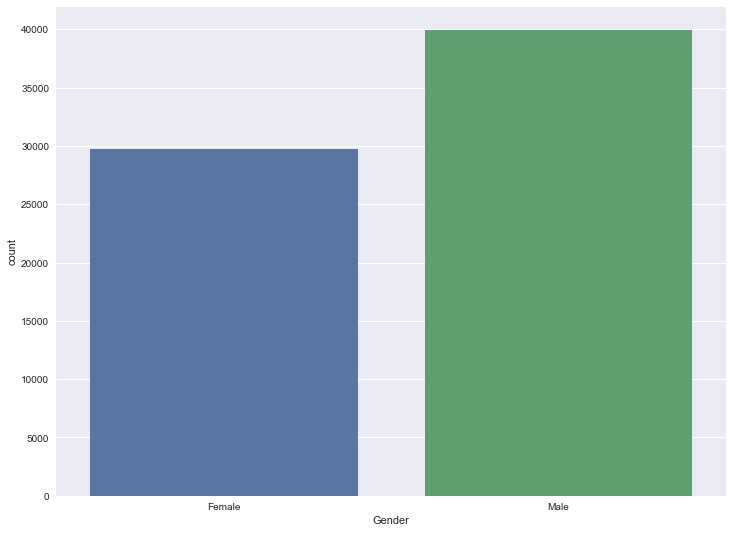

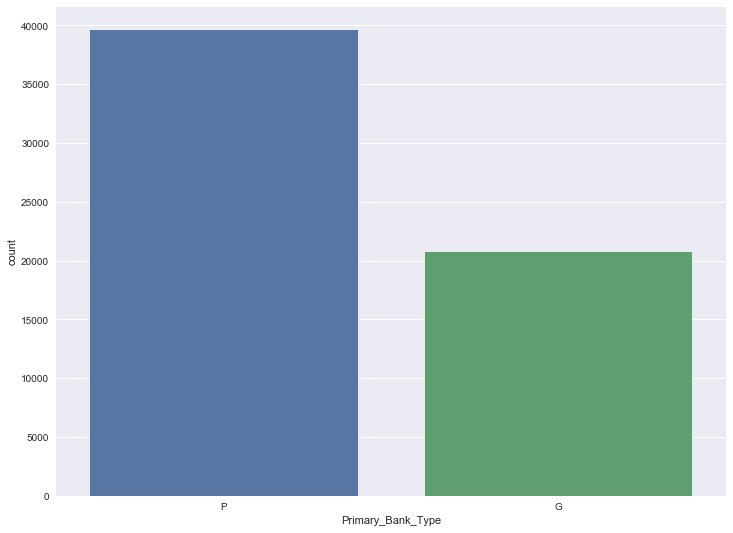

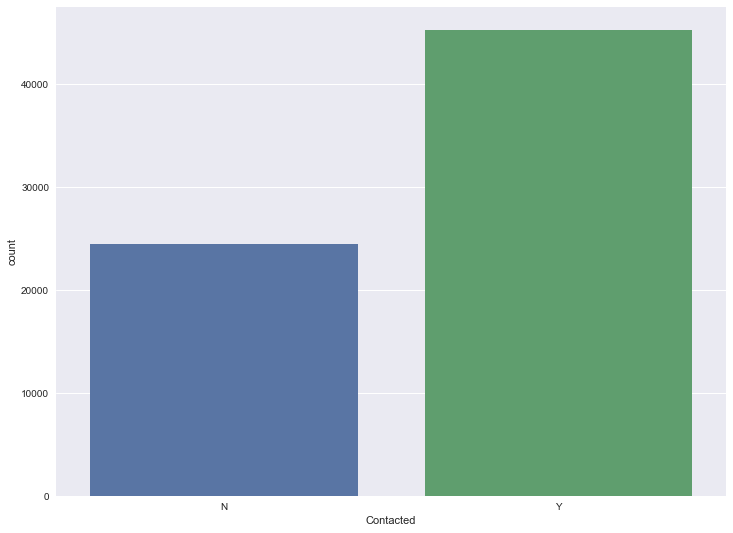

In [28]:
#EDA plots - 1 
#Univariate analysis - Checking distribution of binary variables
for i in df_binary_col:
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 9)
    sns.countplot(x=i, data=df_cat);
    plt.show()

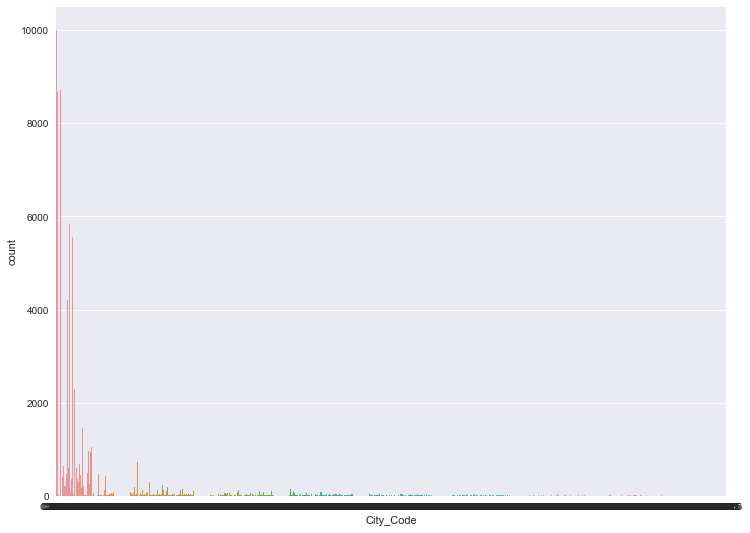

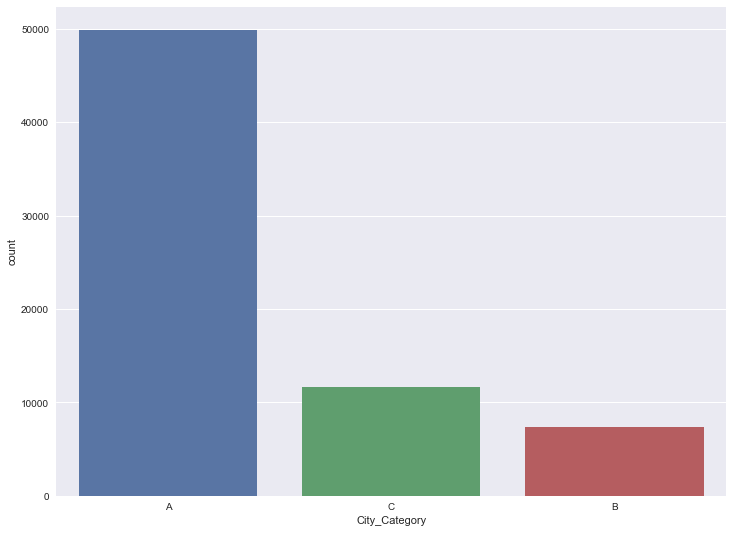

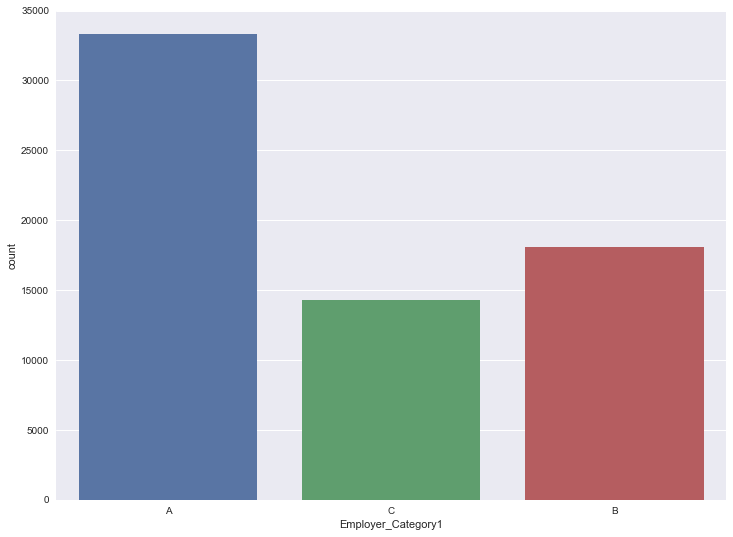

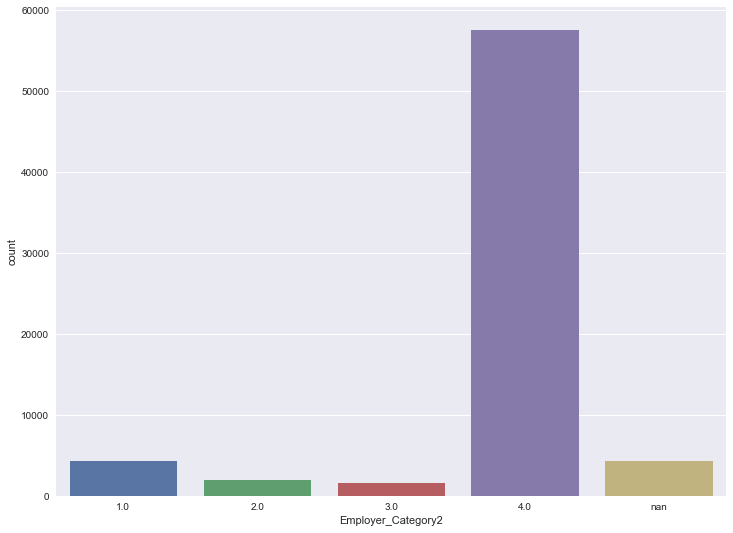

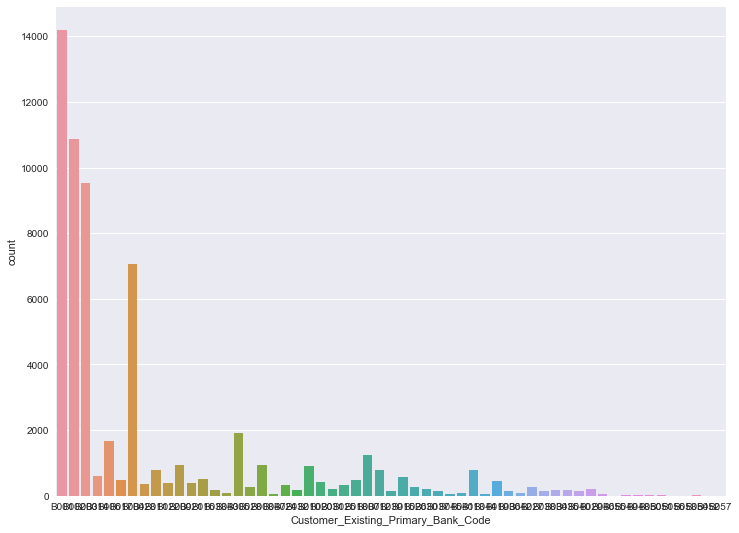

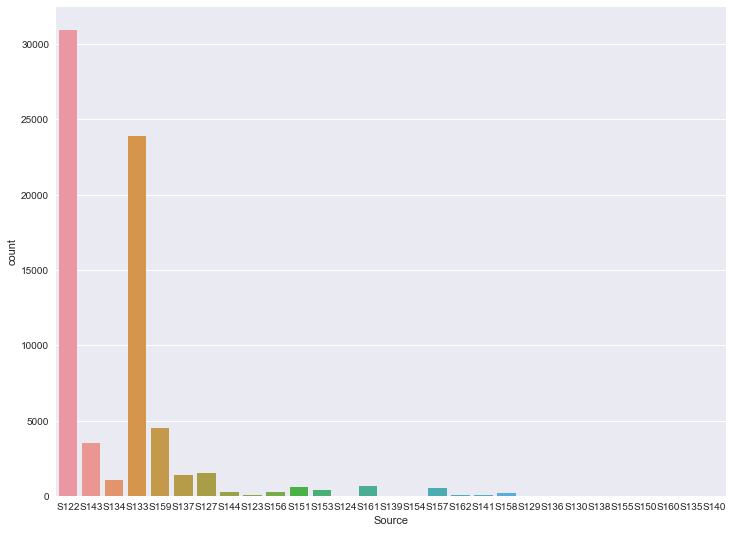

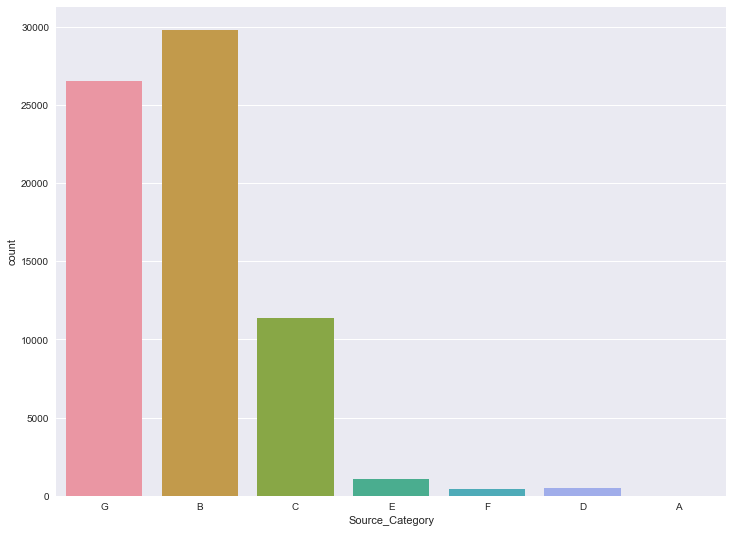

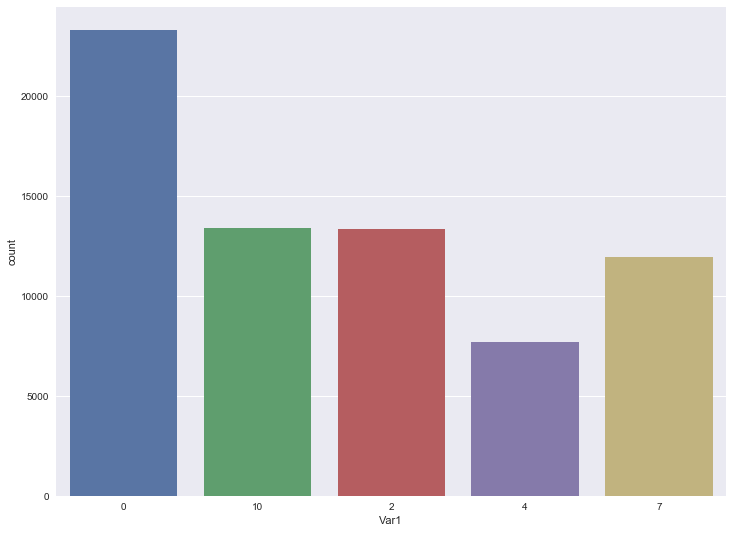

In [29]:
#EDA plots - 2 
#Univariate analysis - Checking distribution of nominal variables
for i in df_nominal_col:
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 9)
    sns.countplot(x=i, data=df_cat);
    plt.show()

In [31]:
#EDA plots - 2 (Test)
#Univariate analysis - Checking distribution of nominal variables
for i in df_nominal_col:
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 9)
    sns.countplot(x=i, data=df_test_cat);
    plt.show()

In [ ]:
#EDA plots - 3
#Univariate analysis - Checking distribution of numerical variables using histogram
for i in df_num_col:
    df_num.hist(column=i, bins = 100)
    plt.show()

In [ ]:
# df_num.describe()

In [ ]:
# #Eliminate Variables by intuition
# df_num_col.remove('zip') #Not suitable for prediction - too many values
# df_num = df_num[df_num_col]
# df_binary_col.remove('FRX_PrevQ1_N') #Not suitable for prediction - single value

In [ ]:
#EDA plots - 4
#Target distribution
df_Y_col = df_Y.index.values.tolist()
fig, ax = plt.subplots()
fig.set_size_inches(12, 9)
sns.countplot(x = df_Y_col, data=df_Y);
plt.show()

In [ ]:
#EDA - 5 Bi-variate analysis on binary variables
for i in df_binary_col:
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 9)
    sns.countplot(x=i, data=df, hue='Approved')
    plt.show()

In [ ]:
#EDA - 6 Bi-variate analysis on nominal variables
for i in df_nominal_col:
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 9)
    sns.countplot(x=i, data=df, hue='Approved')
    plt.show()

In [ ]:
dstnct_cnt_col

In [257]:
df = df_bkp

In [258]:
df = df.drop(['ID','Employer_Code'], axis =1)

In [259]:
##Reducing categories by binning categorical variables
a = df.City_Code.value_counts()
# print (a)
#get top 5 values of index
vals = a[:5].index
# print (vals)
df['City_Code_new'] = df.City_Code.where(df.City_Code.isin(vals), 'other')
df = df.drop(['City_Code'],axis=1)

In [260]:
a = df.Customer_Existing_Primary_Bank_Code.value_counts()
# print (a)
#get top 4 values of index
vals = a[:4].index
# print (vals)
df['Customer_Existing_Primary_Bank_Code_new'] = df.Customer_Existing_Primary_Bank_Code.where(df.Customer_Existing_Primary_Bank_Code.isin(vals), 'other')
df = df.drop(['Customer_Existing_Primary_Bank_Code'],axis=1)

In [261]:
a = df.Source.value_counts()
# print (a)
#get top 4 values of index
vals = a[:4].index
# print (vals)
df['Source_new'] = df.Source.where(df.Source.isin(vals), 'other')
df = df.drop(['Source'],axis=1)

In [262]:
a = df.Source_Category.value_counts()
# print (a)
#get top 3 values of index
vals = a[:3].index
# print (vals)
df['Source_Category_new'] = df.Source_Category.where(df.Source_Category.isin(vals), 'other')
df = df.drop(['Source_Category'],axis=1)

In [263]:
#Filter columns into numerical & categorical
df_num = df.select_dtypes(include=[np.number]) #Numbers which are categories must be verified
df_cat = df.select_dtypes(exclude=[np.number])

In [264]:
df_cat_col = non_missing_col(df_cat)
df_cat = df_cat[df_cat_col]

In [265]:
#Find Count of distinct values in categorical fields
count = df_cat.apply(pd.Series.nunique)
dstnct_cnt_col = pd.DataFrame(count, columns=['count'])
dstnct_cnt_col

,count
Gender,2
City_Category,3
Employer_Category1,3
Employer_Category2,5
Primary_Bank_Type,2
Contacted,2
Var1,5
City_Code_new,6
Customer_Existing_Primary_Bank_Code_new,5
Source_new,5


In [266]:
#Nominal Variables(2+)
df_nominal_col = dstnct_cnt_col.loc[dstnct_cnt_col['count'] >2]
df_nominal_col = df_nominal_col.index.values.tolist()
df_nominal = df_cat[df_nominal_col]

In [267]:
df.head(5)

,Gender,City_Category,Employer_Category1,Employer_Category2,Monthly_Income,Primary_Bank_Type,Contacted,Existing_EMI,Loan_Amount,Loan_Period,Interest_Rate,EMI,Var1,Approved,Age,City_Code_new,Customer_Existing_Primary_Bank_Code_new,Source_new,Source_Category_new
0,Female,A,A,4.0,2000.0,P,N,0.0,NaN,NaN,NaN,NaN,0,0,37,C10001,B001,S122,G
1,Male,A,C,1.0,3500.0,P,Y,0.0,20000.0,2.0,13.25,953.0,10,0,30,C10003,B002,S122,G
2,Male,C,C,4.0,2250.0,G,Y,0.0,45000.0,4.0,NaN,NaN,0,0,34,other,B003,S143,B
3,Male,C,A,4.0,3500.0,G,Y,0.0,92000.0,5.0,NaN,NaN,7,0,28,other,B003,S143,B
4,Male,A,A,4.0,10000.0,P,Y,2500.0,50000.0,2.0,NaN,NaN,10,0,31,C10002,B001,other,B


In [268]:
# df_test = df_test_bkp

In [269]:
Cust_id_test = df_test[['ID']]

In [270]:
print df.shape, df_test.shape

(69713, 19) (30037, 20)


In [271]:
df.head(5)

,Gender,City_Category,Employer_Category1,Employer_Category2,Monthly_Income,Primary_Bank_Type,Contacted,Existing_EMI,Loan_Amount,Loan_Period,Interest_Rate,EMI,Var1,Approved,Age,City_Code_new,Customer_Existing_Primary_Bank_Code_new,Source_new,Source_Category_new
0,Female,A,A,4.0,2000.0,P,N,0.0,NaN,NaN,NaN,NaN,0,0,37,C10001,B001,S122,G
1,Male,A,C,1.0,3500.0,P,Y,0.0,20000.0,2.0,13.25,953.0,10,0,30,C10003,B002,S122,G
2,Male,C,C,4.0,2250.0,G,Y,0.0,45000.0,4.0,NaN,NaN,0,0,34,other,B003,S143,B
3,Male,C,A,4.0,3500.0,G,Y,0.0,92000.0,5.0,NaN,NaN,7,0,28,other,B003,S143,B
4,Male,A,A,4.0,10000.0,P,Y,2500.0,50000.0,2.0,NaN,NaN,10,0,31,C10002,B001,other,B


In [272]:
#Training_Validation Split
df_train, df_validation = train_test_split(df,test_size=0.20,random_state=190)
print "Train shape : ",df_train.shape
print "Validation shape : ",df_validation.shape

Train shape :  (55770, 19)
Validation shape :  (13943, 19)


In [273]:
#training Target
train_Y = df_train ['Approved']
validation_Y = df_validation ['Approved']
print train_Y.shape, validation_Y.shape

(55770,) (13943,)


In [274]:
df_train = df_train.drop(['Approved'], axis =1)
df_validation = df_validation.drop(['Approved'], axis =1)
print "Train shape : ",df_train.shape
print "Validation shape : ",df_validation.shape

Train shape :  (55770, 18)
Validation shape :  (13943, 18)


In [275]:
df_train_num = df_train[df_num_col]
df_validation_num = df_validation[df_num_col]
df_test_num = df_test[df_num_col]

In [276]:
print df_train_num.shape, df_validation_num.shape, df_test_num.shape

(55770, 7) (13943, 7) (30037, 7)


In [277]:
#Impute median values for numerical variables
def impute_median(df):
    fill_NaN = Imputer(missing_values=np.nan, strategy='median', axis=1)
    imputed_df = pd.DataFrame(fill_NaN.fit_transform(df))
    imputed_df.columns = df.columns
    imputed_df.index = df.index
    return imputed_df

In [278]:
imputed_df_train_num = impute_median(df_train_num)
imputed_df_validation_num = impute_median(df_validation_num)
imputed_df_test_num = impute_median(df_test_num)

In [279]:
print imputed_df_train_num.shape, imputed_df_validation_num.shape, imputed_df_test_num.shape

(55770, 7) (13943, 7) (30037, 7)


In [280]:
df_nominal_col

['City_Category',
 'Employer_Category1',
 'Employer_Category2',
 'Var1',
 'City_Code_new',
 'Customer_Existing_Primary_Bank_Code_new',
 'Source_new',
 'Source_Category_new']

In [281]:
#Handling Categorical variables
df_train_nominal = df_train[df_nominal_col]
df_validation_nominal = df_validation[df_nominal_col]

In [284]:
df_test_cat = df_test[df_cat_col]
df_test_nominal = df_test[df_nominal_col]

In [302]:
print df_test_cat.shape, df_test_nominal.shape

In [285]:
def impute_mode(df):
    imputed_df = df.apply(lambda x:x.fillna(x.value_counts().index[0]))
    return imputed_df

In [287]:
imputed_df_train_nominal = impute_mode(df_train_nominal)
imputed_df_validation_nominal = impute_mode(df_validation_nominal)
imputed_df_test_nominal = impute_mode(df_test_nominal)

In [288]:
#Function to creating dummy variables for Nominal fields for a set of columns
def create_dummy_set(df_col,df):
    for i in df_col:
        dummies = pd.get_dummies(df[i]).rename(columns=lambda x: i+'_'+ str(x))
        #Adding to input variables
        df = pd.concat([df, dummies], axis=1)
        #Dropping column without having to reassign
        df.drop([i], inplace=True, axis=1)
        print df.shape
    return df

In [290]:
df_train_nominal = create_dummy_set(df_nominal_col,imputed_df_train_nominal)
df_validation_nominal = create_dummy_set(df_nominal_col,imputed_df_validation_nominal)
df_test_nominal = create_dummy_set(df_nominal_col,imputed_df_test_nominal)

(55770, 10)
(55770, 12)
(55770, 16)
(55770, 20)
(55770, 25)
(55770, 29)
(55770, 33)
(55770, 36)
(13943, 10)
(13943, 12)
(13943, 16)
(13943, 20)
(13943, 25)
(13943, 29)
(13943, 33)
(13943, 36)


In [291]:
df_train_binary = df_train[df_binary_col]
df_validation_binary = df_validation[df_binary_col]
# df_test_binary = df_test[df_binary_col]

In [292]:
df_train_binary = create_dummy_set(df_binary_col,df_train_binary)
df_validation_binary = create_dummy_set(df_binary_col,df_validation_binary)
df_train_binary = df_train_binary[df_train_binary.columns.drop(list(df_train_binary.filter(regex='MISSING')))]
df_validation_binary = df_validation_binary[df_validation_binary.columns.drop(list(df_validation_binary.filter(regex='MISSING')))]

(55770, 4)
(55770, 5)
(55770, 6)
(13943, 4)
(13943, 5)
(13943, 6)


In [228]:
df_test_binary = create_dummy_set(df_binary_col,df_test_binary)
df_test_binary = df_test_binary[df_test_binary.columns.drop(list(df_test_binary.filter(regex='MISSING')))]

(30037, 4)
(30037, 5)
(30037, 6)


In [229]:
df_test_binary.head(5)

,Gender_Female,Gender_Male,Primary_Bank_Type_G,Primary_Bank_Type_P,Contacted_N,Contacted_Y
0,0,1,0,1,0,1
1,0,1,0,1,0,1
2,1,0,0,1,1,0
3,1,0,0,1,1,0
4,0,1,0,1,0,1


In [230]:
# df_train_binary.drop('EFT_SELF_TRANSFER_PrevQ1_N', axis=1, inplace=True)
# df_validation_binary.drop('EFT_SELF_TRANSFER_PrevQ1_N', axis=1, inplace=True)
# df_test_binary.drop('EFT_SELF_TRANSFER_PrevQ1_N', axis=1, inplace=True)

In [293]:
df_train = imputed_df_train_num.join(df_train_nominal).join(df_train_binary)
print df_train.shape

(55770, 49)


In [294]:
df_validation = imputed_df_validation_num.join(df_validation_nominal).join(df_validation_binary)
print df_validation.shape

(13943, 49)


In [233]:
df_test = imputed_df_test_num.join(df_test_nominal).join(df_test_binary)
print df_test.shape

(30037, 112)


In [295]:
print df_train.shape, df_validation.shape, df_test.shape

(55770, 49) (13943, 49) (30037, 20)


In [301]:
df_train.head(5)

,Monthly_Income,Existing_EMI,Loan_Amount,Loan_Period,Interest_Rate,EMI,Age,City_Category_A,City_Category_B,City_Category_C,Employer_Category1_A,Employer_Category1_B,Employer_Category1_C,Employer_Category2_1.0,Employer_Category2_2.0,Employer_Category2_3.0,Employer_Category2_4.0,Employer_Category2_nan,Var1_0,Var1_10,Var1_2,Var1_4,Var1_7,City_Code_new_C10001,City_Code_new_C10002,City_Code_new_C10003,City_Code_new_C10004,City_Code_new_C10005,City_Code_new_other,Customer_Existing_Primary_Bank_Code_new_B001,Customer_Existing_Primary_Bank_Code_new_B002,Customer_Existing_Primary_Bank_Code_new_B003,Customer_Existing_Primary_Bank_Code_new_B004,Customer_Existing_Primary_Bank_Code_new_other,Source_new_S122,Source_new_S133,Source_new_S143,Source_new_S159,Source_new_other,Source_Category_new_B,Source_Category_new_C,Source_Category_new_G,Source_Category_new_other,Gender_Female,Gender_Male,Primary_Bank_Type_G,Primary_Bank_Type_P,Contacted_N,Contacted_Y
49012,1900.0,700.0,700.0,700.0,700.0,700.0,24.0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,1,0
52042,2000.0,470.0,10000.0,3.0,28.5,416.0,24.0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,1
9588,5800.0,0.0,100000.0,5.0,17.5,2512.0,36.0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,1,0,0,1
18631,2100.0,0.0,47000.0,5.0,27.0,27.0,27.0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1
45509,2500.0,0.0,20.0,20.0,20.0,20.0,20.0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1


In [296]:
_xgb = xgb.XGBClassifier(objective='binary:logistic',max_depth=5,n_estimators=1000,colsample_bytree=.75,learning_rate=0.06).fit(df_train, train_Y,eval_metric='auc')
train_pred = _xgb.predict_proba(df_train)
val_pred = _xgb.predict_proba(df_validation)

In [297]:
train_pred_val = _xgb.predict(df_train)
val_pred_val = _xgb.predict(df_validation)
print recall_score(train_Y, train_pred_val)
print recall_score(validation_Y, val_pred_val)
print confusion_matrix(train_Y, train_pred_val)
print confusion_matrix(validation_Y, val_pred_val)

0.199753390875
0.0
[[54959     0]
 [  649   162]]
[[13729     5]
 [  209     0]]


[  1.78344652e-01   7.19837993e-02   1.03569083e-01   4.51609381e-02
   9.10882428e-02   1.12163343e-01   9.63980705e-02   7.00678769e-03
   8.48478172e-03   3.99605883e-03   1.62579380e-02   1.01817390e-02
   1.24808410e-02   4.43398301e-03   2.79176701e-03   5.63827436e-03
   6.62360433e-03   1.97065901e-03   5.96671784e-03   9.47011169e-03
   2.13488075e-03   4.05079918e-03   6.45938236e-03   1.35209113e-02
   1.03459600e-02   8.53952300e-03   4.54346417e-03   4.65294486e-03
   1.26998033e-02   1.22618787e-02   1.26998033e-02   5.36457170e-03
   4.76242602e-03   9.25114937e-03   1.31924674e-02   1.46157211e-02
   4.92664753e-03   3.01072909e-03   4.81716683e-03   1.10028461e-02
   5.85723668e-03   9.63433366e-03   2.73702643e-03   5.52879367e-03
   1.75169692e-03   7.82789569e-03   8.70374404e-03   9.30588983e-04
   1.64221594e-04]


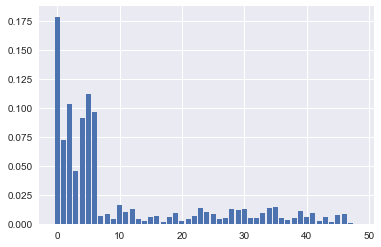

In [298]:
# feature importance
print(_xgb.feature_importances_)
# plot
plt.bar(range(len(_xgb.feature_importances_)), _xgb.feature_importances_)
plt.show()

In [300]:
ax = plot_importance(_xgb, max_num_features=50, ax=ax)
fig = ax.figure
fig.set_size_inches(18.5, 10.5)
fig.savefig('../Documents/JK/McKinsey2/feature_imp.png', dpi=1000)
plt.show()

In [87]:
test_pred = _xgb.predict_proba(df_test)

In [88]:
df_test_pred = pd.DataFrame(test_pred.tolist())

In [89]:
predicted_result = Cust_id_test.join(df_test_pred)

In [90]:
predicted_result = predicted_result.rename(columns = {0 : 'Non-Responders', 1 : 'Responders'})

In [91]:
predicted_result = predicted_result.drop('Non-Responders', 1)

In [92]:
predicted_result.shape

(200000, 2)

In [93]:
predicted_result.head(10)

,UCIC_ID,Responders
0,337734,0.306662
1,488166,0.026406
2,410785,0.058713
3,389145,0.137313
4,221090,0.178707
5,2651,0.015014
6,344310,0.046792
7,53881,0.023039
8,499665,0.062556
9,482927,0.049796


In [94]:
predicted_result.to_csv("Documents/JK/churn_prediction/BOG_SB_output.csv",sep=',',index=False)